In [1]:
import math
import torch
import gpytorch
import cf_units
import datetime
import zarr
import dask

import dask.array as dsa
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
sea_level_picontrol = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol.zarr')

pacific = sea_level_picontrol[dict(time=2000)].sel(xt_ocean=slice(-120,-115), yt_ocean=slice(-10,-5.1))

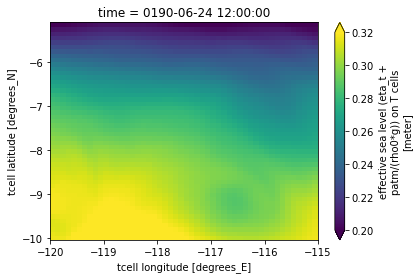

In [3]:
# Plot sea level of selected area
pacific['sea_level'].plot(vmin = 0.20, vmax = 0.32)

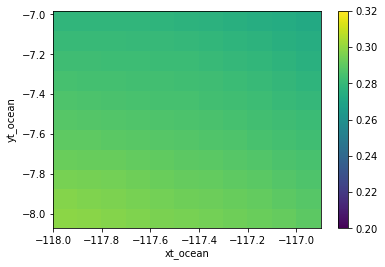

In [34]:
sea_df = pacific['sea_level'].to_pandas()
test_chunk = sea_df.iloc[20:31, 20:31]
training = sea_df[~sea_df.isin(test_chunk)]

#Plot Chunk
xr.DataArray(test_chunk).plot(vmin = 0.20, vmax = 0.32)

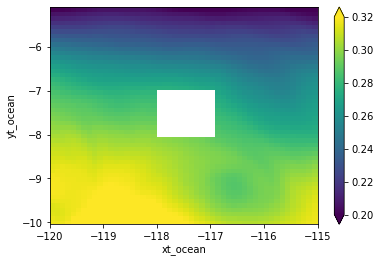

In [5]:
#Plot Training Data
xr.DataArray(training).plot(vmin = 0.20, vmax = 0.32)

In [21]:
#What do we do with NaN values? Do we set them to mean?
def format_sea_level(data):
    formatted = []
    for i in range(len(data)):
        formatted.append(data[i])
    
    return torch.FloatTensor((np.array(formatted)).astype(float) ).squeeze()

#Sea values at coordinate locations
sea_info = training.stack().reset_index()
train_y = format_sea_level(np.array(sea_info[0]))
print(y_train)

tensor([0.3171, 0.3168, 0.3169,  ..., 0.1986, 0.1982, 0.1979])


In [30]:
# Calculate mean std of x and y variables
train_x = torch.tensor(np.vstack((sea_info['yt_ocean'], sea_info['xt_ocean'])).T)

ytrain_mean = train_y.mean()
ytrain_std = train_y.std()

# Normalize training data
train_y = (y_train - y_train.mean()) / y_train.std()

#Test
# y_test = torch_sea_array[1000:2000].float()
# test_y = torch.FloatTensor(y_test).squeeze()

# # Normalize testing data
# test_y = (test_y - ytrain_mean) / ytrain_std


# # Full prediction
# full_x = torch.cat((x_train, test_x))

# print(train_x.shape)
# print(train_y.shape)
# print(test_x.shape)
# print(test_y.shape)

In [31]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        x_mean = self.mean_module(x)
        x_covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(x_mean, x_covar)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)


hypers = {
    'covar_module.base_kernel.lengthscale': torch.tensor(1.7),
}

model.initialize(**hypers)

print(
    model.covar_module.base_kernel.lengthscale.item(),
)


1.7000000476837158


In [32]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)

        
    loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.lengthscale.item(),
#         model.likelihood.noise.item()
#     ))
    optimizer.step()


TypeError: rsub() received an invalid combination of arguments - got (Tensor, numpy.ndarray), but expected one of:
 * (Tensor input, Tensor other, *, Number alpha)
 * (Tensor input, Number other, Number alpha)


In [54]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

n=1000
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    train_pred = model(train_x).mean.detach()
#     print(observed_pred.mean)

import matplotlib.pyplot as plt
%matplotlib inline

pred_labels = observed_pred.mean.view(n)

# Calc abosolute error
test_y_actual = test_y
delta_y = torch.abs(pred_labels - test_y_actual).detach().numpy()

torch.Size([1000])
torch.Size([1000])


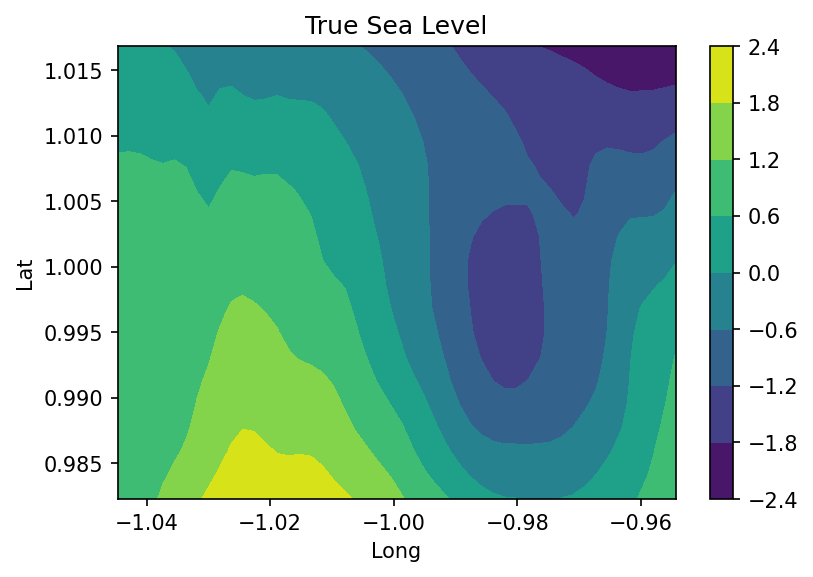

In [55]:
train_X_1, train_X_2 = np.meshgrid(train_x[:,1].unique(),train_x[:,0].unique())

print(train_x[:,1].shape)
print(test_x[:,1].shape)

plt.figure(dpi=150)
plt.contourf(train_X_1, train_X_2,
             train_y.reshape(train_X_2.shape))
plt.title("True Sea Level")
plt.xlabel("Long")
plt.ylabel("Lat")
plt.colorbar()
plt.show()

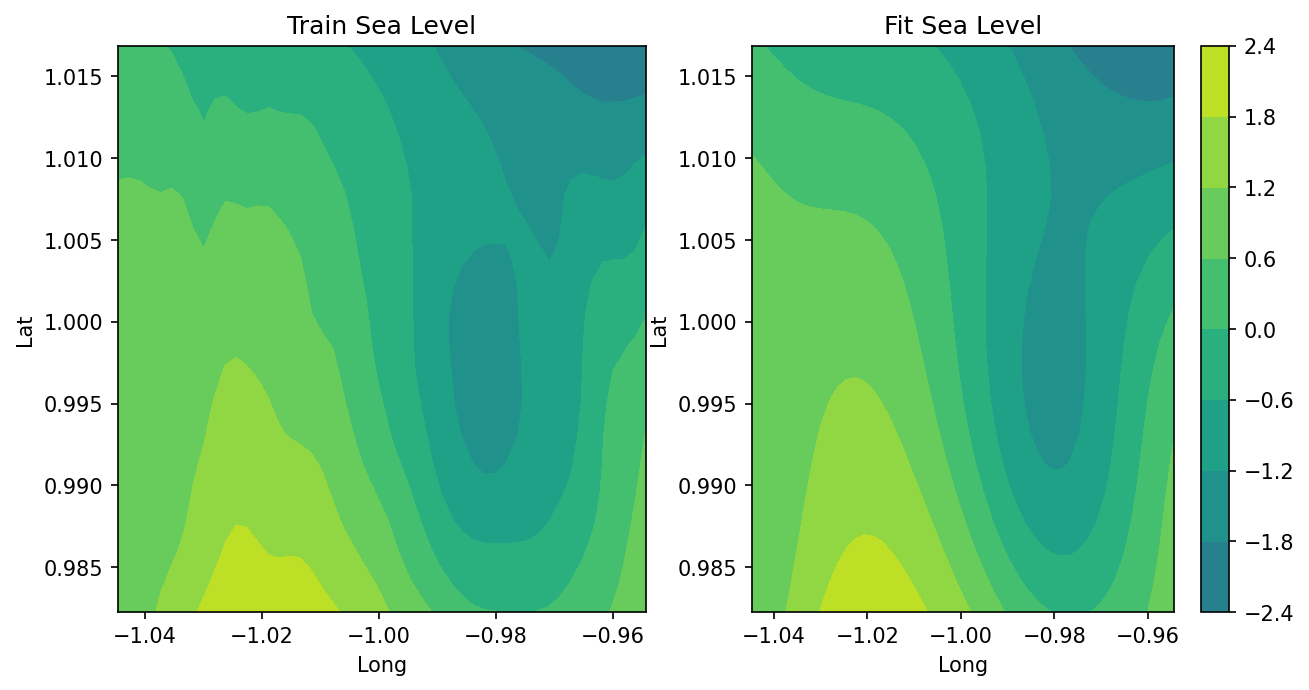

In [56]:
train_X_1, train_X_2 = np.meshgrid(train_x[:,1].unique(),train_x[:,0].unique())
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 5))

ax[0].contourf(train_X_1, train_X_2,
             train_y.reshape(train_X_2.shape), vmin=-6, vmax=3.)
ax[0].set_title("Train Sea Level")
ax[0].set_xlabel("Long")
ax[0].set_ylabel("Lat")

contour_ = ax[1].contourf(train_X_1, train_X_2,
             train_pred.reshape(train_X_2.shape), vmin=-6, vmax=3.)
ax[1].set_title("Fit Sea Level")
ax[1].set_xlabel("Long")
ax[1].set_ylabel("Lat")
fig.colorbar(contour_)
plt.show()

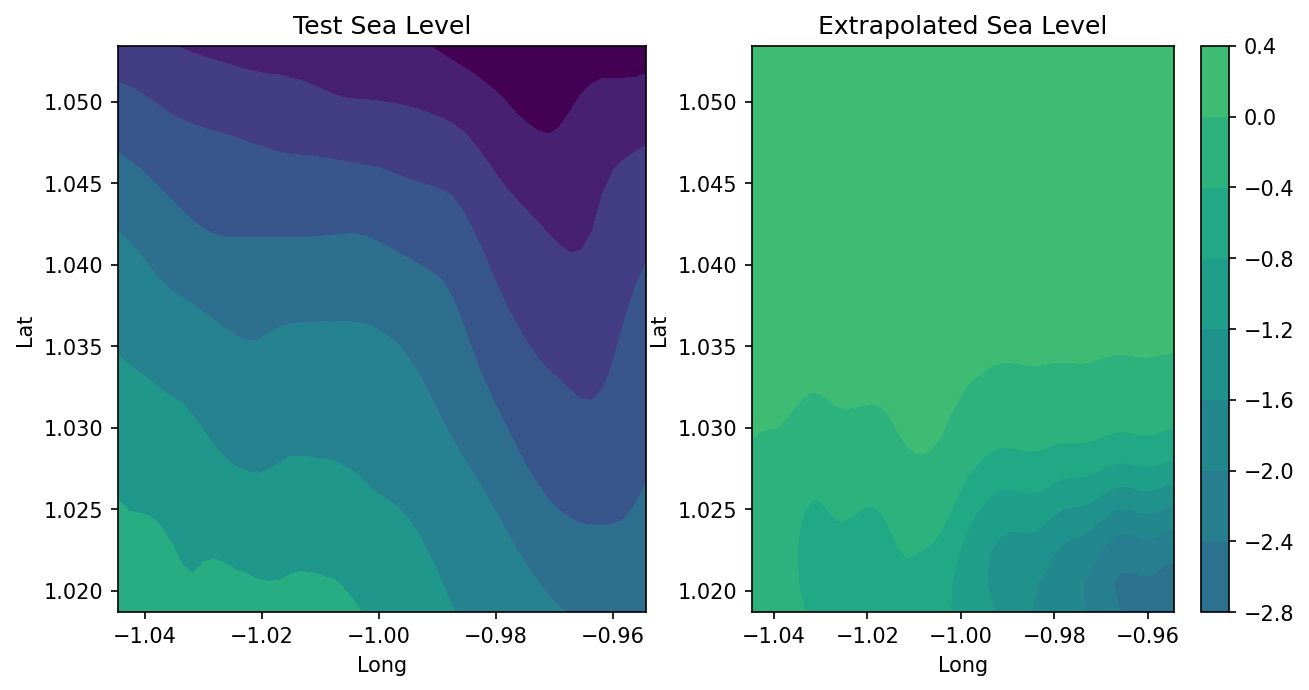

In [36]:
test_X_1, test_X_2 = np.meshgrid(test_x[:,1].unique(),test_x[:,0].unique())

fig, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 5))

ax[0].contourf(test_X_1, test_X_2,
             test_y.reshape(test_X_2.shape),vmin=-6, vmax=3.) 
ax[0].set_title("Test Sea Level")
ax[0].set_xlabel("Long")
ax[0].set_ylabel("Lat")

contour_ = ax[1].contourf(test_X_1, test_X_2,
             pred_labels.detach().reshape(test_X_2.shape),vmin=-6, vmax=3.)
ax[1].set_title("Extrapolated Sea Level")
ax[1].set_xlabel("Long")
ax[1].set_ylabel("Lat")
fig.colorbar(contour_)
plt.show()